# Introduction
In this small project we will take a look at Seattle weather dataset from Kaggle to extract important features and use them to test functionality of Recurrent Neural Network.
<br><br>
#### Main objective
Build a model using PyTorch library that predicts temperature for the next day.
<br><br>
#### Process includes:
1. **Data** <br>
&ensp;1.1 Overview <br>
&ensp;1.2 Anomalies <br>
&ensp;1.3 Visualization <br>
&ensp;1.4 Preparing data for model <br>
2. **Building model** <br>
&ensp;2.1 Train / test split <br>
&ensp;2.2 Sequencing datasets <br>
&ensp;2.3 Class LSTM <br>
&ensp;2.4 Training function <br>
&ensp;2.5 Testing function <br>
&ensp;2.6 Training and Testing the RNN models <br>
3. **Conclusion**

#### Setup

In [1]:
import matplotlib.pyplot as plt

WHITE_MID = '#b5b5b5'
GREY_DARK = '#141414'

plt.rcParams['figure.facecolor'] = GREY_DARK
plt.rcParams['text.color'] = WHITE_MID
plt.rcParams['axes.facecolor'] = GREY_DARK
plt.rcParams['axes.edgecolor'] = WHITE_MID
plt.rcParams['axes.labelcolor'] = WHITE_MID
plt.rcParams['axes.titlecolor'] = WHITE_MID

plt.rcParams['grid.color'] = WHITE_MID
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.color'] = WHITE_MID
plt.rcParams['ytick.color'] = WHITE_MID
plt.rcParams['legend.edgecolor'] = WHITE_MID
plt.rcParams['legend.labelcolor'] = WHITE_MID

In [2]:
import numpy as np
import torch
import random
import warnings

warnings.filterwarnings("ignore")

seed = 42

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#### Load Data

In [3]:
import pandas as pd

df = pd.read_csv('../datasets/weather-processed.csv')
df

,precipitation,wind,temp_avg
0,0.0,4.7,8.90
1,10.9,4.5,6.70
2,0.8,2.3,9.45
3,20.3,4.7,8.90
4,1.3,6.1,5.85
...,...,...,...
1456,8.6,2.9,3.05
1457,1.5,1.3,3.35
1458,0.0,2.6,3.90
1459,0.0,3.4,2.30


#### Scale data

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = ['precipitation', 'temp_avg', 'wind']

df.loc[:, features] = scaler.fit_transform(df[features]) # applying scaled features to numeric features

df.describe()

,precipitation,wind,temp_avg
count,1461.000000,1461.000000,1461.000000
mean,0.054194,0.312213,0.529080
std,0.119503,0.158003,0.196657
min,0.000000,0.000000,0.000000
25%,0.000000,0.197802,0.378689
50%,0.000000,0.285714,0.516393
75%,0.050089,0.395604,0.688525
max,1.000000,1.000000,1.000000


#### Train / test split

In [5]:
train_size = int(len(df) * 0.7) + 1
test_size = int(len(df) * 0.3)

print(
    f"{f"train size":>12}: {train_size}",
    f"{f"test size":>12}: {test_size}",
    len(df) == train_size + test_size,
    sep='\n'
)

  train size: 1023
   test size: 438
True


In [6]:
df_train = df[:train_size]
df_test = df[train_size:]

We're going to pass sequenced data with length of 7 days per sequence. <br>
Knowing that, we have to make sure that our datasets are divisible by 7. <br>

In [7]:
df_train = df_train[:(len(df_train) // 7) * 7]
df_test = df_test[:(len(df_test) // 7) * 7]

In [8]:
print(
    len(df_train),
    len(df_test), sep='\n'
)

1022
434


Convert each data split to numpy, so we're able to pass it to torch.

In [9]:
df_train_torch = df_train.to_numpy()
df_train_torch = torch.tensor(df_train_torch)

df_test_torch = df_test.to_numpy()
df_test_torch = torch.tensor(df_test_torch)
df_test_torch[:7]

tensor([[0.2093, 0.2967, 0.5885],
        [0.0179, 0.4725, 0.5803],
        [0.5725, 0.5055, 0.5721],
        [0.1682, 0.4615, 0.4967],
        [0.0733, 0.3077, 0.5066],
        [0.1091, 0.5495, 0.5344],
        [0.0268, 0.5055, 0.4623]], dtype=torch.float64)

#### 2.2 - Sequencing datasets
To predict temperature based on features from past 6 days, <br>
we have to reshape our data split sets to return specific sequences. <br><br>
Each sequence containing data from 7 days, where: <br>
X - temp_avg features from first 6 days <br>
y - same features, but we take just day 7th

In [10]:
from torch.utils.data import TensorDataset, DataLoader

def sequence_dataset(dataset, batch_size, extra_features=False):
    
    x, y = [], []
    
    for i in range(0, len(dataset) - 7, 7):
        
        if extra_features:
            week = dataset[i: i + 7, :] # take precipitation, wind and temperature (:)
        else:
            week = dataset[i: i + 7, 2] # take just the temperature (2)
        week_input = week[:6] # trim to 6 days
        week_target = week[6] # take last day
        
        x.append(week_input)
        y.append(week_target)
        
    # covert to tensor dataset
    tensor_dataset = TensorDataset(torch.tensor(np.asarray(x)),
                                   torch.tensor(np.asarray(y)))
    
    # covert to data_loader
    data_loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    return data_loader

In [11]:
batch_size = 8
train_loader = sequence_dataset(df_train_torch, batch_size=batch_size)
test_loader = sequence_dataset(df_test_torch, batch_size=batch_size)

In [12]:
for batch in train_loader:
    input, target = batch
    # print(input, target)
    print(input.size())
    print(target.size())
    # print(len(target))
    break

torch.Size([8, 6])
torch.Size([8])


In [13]:
for batch in train_loader:
    input, target = batch
    print(input[0], target[0], sep='\n')
    break

tensor([0.6705, 0.7344, 0.6984, 0.7164, 0.7082, 0.6623], dtype=torch.float64)
tensor(0.6541, dtype=torch.float64)


#### 2.3 class LSTM
With PyTorch we are able to build simple RNN with Long Short-Term Memory layers by simply attaching _nn.LSTM()_ with specific factors in it. <br>
The __init__ function first initializes the LSTM and fully connected layers. <br>
__*forward()*__ passes our input x to the rnn network then fully connects it to finally return last value from the output.

In [14]:
from torch import nn

class WeatherRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=3, n_layers=2, dropout=0):
        super(WeatherRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :]) # take the last hidden
        return out

#### 2.4 Training function
So we take our train_loader and pass it to our training function. <br>
Training function iterates over batches for n_epoch times and passes sequences from these batches to our model <br>
that calculates loss by comparing calculated outputs with actual targets using Mean Squared Error function.

In [15]:
import torch.optim as optim

def train_model(model, device, train_loader, n_epochs=1, lr=0.001):
    
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        
        for i, batch in enumerate(train_loader):
            inputs, targets = batch
            inputs, targets = (inputs.to(device).float(),
                               targets.to(device).float())

            inputs = inputs.unsqueeze(-1)
            
            optimizer.zero_grad() # clean gradients
            outputs = model(inputs) # calculate outputs
            
            loss = criterion(outputs, targets.unsqueeze(1)) # add dim
            loss.backward() # backpropagation
            optimizer.step() # update weights
            
            total_loss += loss.item()
            
        print(f"Epoch {epoch + 1} / {n_epochs} finished | {total_loss/len(train_loader):.4f}")

#### 2.5 Testing function
Similar to training function. This time we run the model with no gradients calculations <br>
and iterate through batches from test_loader. <br>
Then return y true and y predicted values to compare where the model makes most mistakes.

In [16]:
def test_model(model, device, test_loader):
    total_loss = 0
    criterion = nn.MSELoss()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            inputs, targets = (inputs.to(device).float(),
                               targets.to(device).float())
            
            inputs = inputs.unsqueeze(-1)

            outputs = model(inputs) # get outputs

            loss = criterion(outputs, targets.unsqueeze(1)) # add dim
            total_loss += loss.item()

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    print(f"Test MSE Loss: {avg_loss:.4f}")

    return y_true, y_pred


#### 2.6 Training and Testing the RNN models

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 1
output_size = 1
hidden_size = 32
n_layers = 1
dropout = 0
learning_rate = 0.001

n_epochs = 30

weather_rnn = WeatherRNN(input_size=input_size, hidden_size=hidden_size, n_layers=n_layers, output_size=output_size, dropout=dropout)

In [41]:
train_model(weather_rnn, device=device, train_loader=train_loader, n_epochs=n_epochs, lr=learning_rate)

Epoch 1 / 30 finished | 0.2633
Epoch 2 / 30 finished | 0.0970
Epoch 3 / 30 finished | 0.0286
Epoch 4 / 30 finished | 0.0219
Epoch 5 / 30 finished | 0.0197
Epoch 6 / 30 finished | 0.0167
Epoch 7 / 30 finished | 0.0138
Epoch 8 / 30 finished | 0.0103
Epoch 9 / 30 finished | 0.0080
Epoch 10 / 30 finished | 0.0073
Epoch 11 / 30 finished | 0.0069
Epoch 12 / 30 finished | 0.0067
Epoch 13 / 30 finished | 0.0066
Epoch 14 / 30 finished | 0.0064
Epoch 15 / 30 finished | 0.0073
Epoch 16 / 30 finished | 0.0069
Epoch 17 / 30 finished | 0.0065
Epoch 18 / 30 finished | 0.0065
Epoch 19 / 30 finished | 0.0064
Epoch 20 / 30 finished | 0.0069
Epoch 21 / 30 finished | 0.0069
Epoch 22 / 30 finished | 0.0066
Epoch 23 / 30 finished | 0.0064
Epoch 24 / 30 finished | 0.0065
Epoch 25 / 30 finished | 0.0063
Epoch 26 / 30 finished | 0.0066
Epoch 27 / 30 finished | 0.0063
Epoch 28 / 30 finished | 0.0066
Epoch 29 / 30 finished | 0.0062
Epoch 30 / 30 finished | 0.0064


In [42]:
y_true, y_pred = test_model(weather_rnn, device=device, test_loader=test_loader)

Test MSE Loss: 0.0079


In [43]:
temp_avg_true = np.array(y_true).flatten()
temp_avg_pred = np.array(y_pred).flatten()

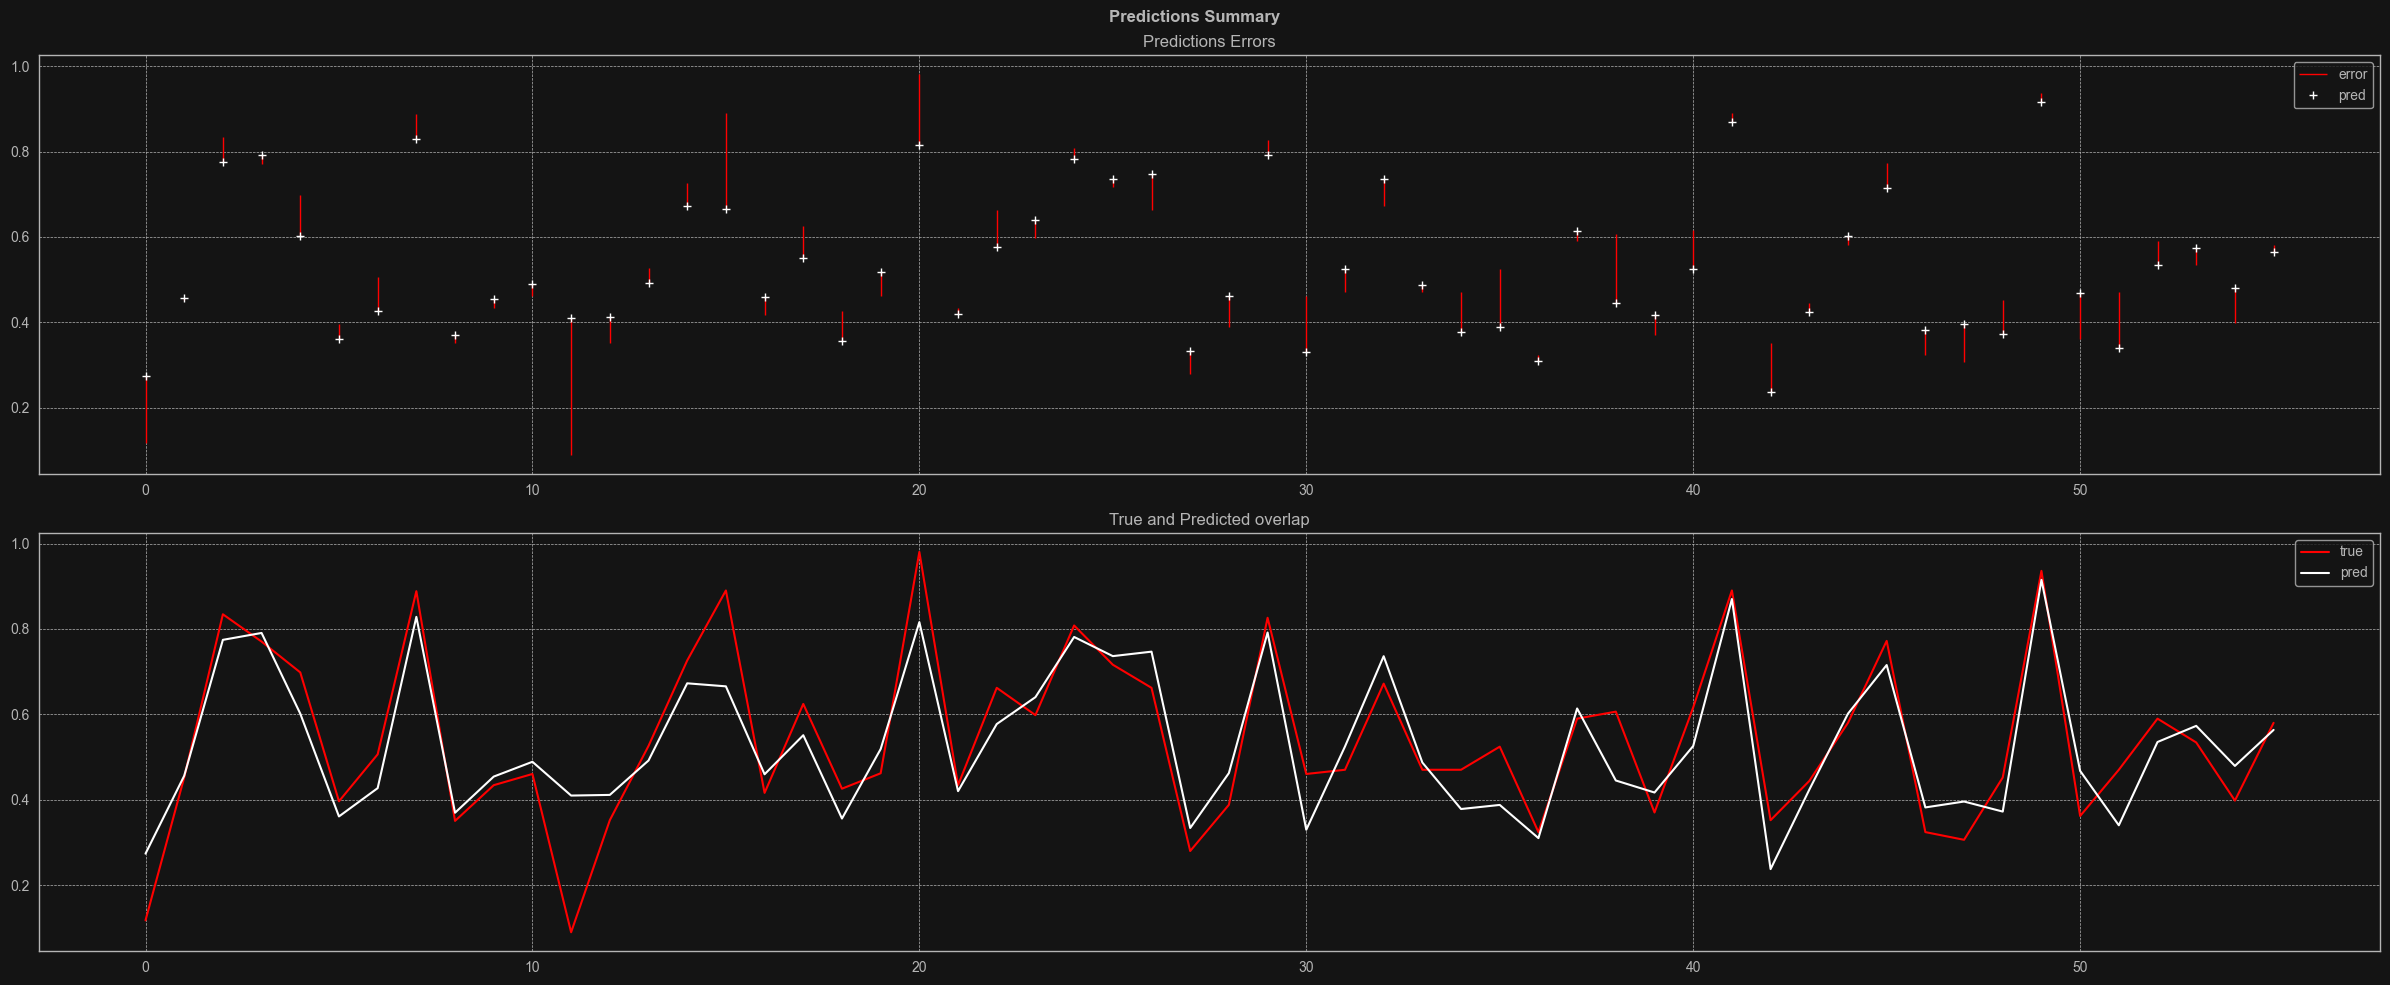

In [44]:
import seaborn as sb

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(24, 10))
axes = axes.flatten()

x = range(len(temp_avg_true))
axes[0].vlines(x=x, ymin=temp_avg_pred, ymax=temp_avg_true, color='red', linewidth=1, label='error')
axes[0].plot(x, y_pred, marker='+', linestyle='None', color='white', label='pred')

sb.lineplot(x=range(len(temp_avg_true)), y=temp_avg_true, color='red', ax=axes[1], label='true')
sb.lineplot(x=range(len(temp_avg_pred)), y=temp_avg_pred, color='white', ax=axes[1], label='pred')

axes[0].set_title('Predictions Errors')
axes[0].legend()

axes[1].set_title('True and Predicted overlap')

plt.suptitle('Predictions Summary', fontweight='bold')
plt.tight_layout()

In [80]:
from scipy.stats import hmean

true_deg = np.zeros((len(temp_avg_true), 3))
pred_deg = np.zeros((len(temp_avg_pred), 3))

true_deg[:, 2] = np.sqrt(temp_avg_true)
pred_deg[:, 2] = np.sqrt(temp_avg_pred)

true_deg = scaler.inverse_transform(true_deg)
pred_deg = scaler.inverse_transform(pred_deg)

error = abs(true_deg - pred_deg)

print(
    f"{"mean":>6}: {error.mean()}",
    f"{"hmean":>6}: {hmean(error[:, 2])}",
    f"{"max":>6}: {error.max()}",
    f"{"min":>6}: {error.min()}",
    f"{"range":>6}: {true_deg.max() - true_deg.min()}",
    sep='\n'
)

  mean: 0.15620828221241634
 hmean: 0.21749606699963753
   max: 3.095256778597831
   min: 0.0
 range: 13.210046923160554


In [81]:
precip_true = np.array(y_true)[:, 0]
precip_pred = np.array(y_pred)[:, 0]

temp_avg_true = np.array(y_true)[:, 1]
temp_avg_pred = np.array(y_pred)[:, 1]

wind_true = np.array(y_true)[:, 2]
wind_pred = np.array(y_pred)[:, 2]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 10))
axes = axes.flatten()

sb.lineplot(x=range(len(precip_true)), y=precip_true, color='red', ax=axes[0], label='True')
sb.lineplot(x=range(len(precip_pred)), y=precip_pred, color='white', ax=axes[0], label='Pred')
axes[0].set_title('precipitation')

sb.lineplot(x=range(len(temp_avg_true)), y=temp_avg_true, color='red', ax=axes[1], label='True')
sb.lineplot(x=range(len(temp_avg_pred)), y=temp_avg_pred, color='white', ax=axes[1], label='Pred')
axes[1].set_title('average temperature')

sb.lineplot(x=range(len(wind_true)), y=wind_true, color='red', ax=axes[2], label='True')
sb.lineplot(x=range(len(wind_pred)), y=wind_pred, color='white', ax=axes[2], label='Pred')
axes[2].set_title('wind speed')

plt.suptitle('Predictions', fontweight='bold')
plt.tight_layout()

# III - Conclusion
Clearly the model doesn't understand the chaos that is in the _precipitation_ and _wind_ columns. <br>
I suppose predicting such thing as weather with both high precision <br>
and large amount of features requires more than just 3 numeric columns. <br>
Despite this fact the model did decent job with predicting average temperature and recognizing patterns inside. <br><br>
Overall I think this project gives quiet simple fundamentals to understand the functionality of Recurrent Neural Networks.
#### Thanks for reading my project, I hope you enjoyed the process :]
_Gracjan Pawłowski 2025_